# Binary Prediction of Poisonous Mushrooms

## About Dataset


The dataset for this competition (both train and test) was generated from a deep learning model trained on the UCI Mushroom dataset. Feature distributions are close to, but not exactly the same, as the original.

Original Dataset: The given information is about the Secondary Mushroom Dataset, the Primary Mushroom Dataset used for the simulation and the respective metadata can be found in the zip.

This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species). Each mushroom is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (the latter class was combined with the poisonous class).

The related Python project contains a Python module secondary_data_generation.py used to generate this data based on primary_data_edited.csv also found in the repository. Both nominal and metrical variables are a result of randomization. The simulated and ordered by species version is found in secondary_data_generated.csv. The randomly shuffled version is found in secondary_data_shuffled.csv.

It has 21 attributes, as below mentioned:

1. **cap-diameter (m):** float number in cm
2. **cap-shape (n):** bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
3. **cap-surface (n):** fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
4. **cap-color (n):** brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
5. **does-bruise-bleed (n):** bruises-or-bleeding=t,no=f
6. **gill-attachment (n):** adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
7. **gill-spacing (n):** close=c, distant=d, none=f
8. **gill-color (n):** see cap-color + none=f
9. **stem-height (m):** float number in cm
10. **stem-width (m):** float number in mm
11. **stem-root (n):** bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
12. **stem-surface (n):** see cap-surface + none=f
13. **stem-color (n):** see cap-color + none=f
14. **veil-type (n):** partial=p, universal=u
15. **veil-color (n):** see cap-color + none=f
16. **has-ring (n):** ring=t, none=f
17. **ring-type (n):** cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
18. **spore-print-color (n):** see cap color
19. **habitat (n):** grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
20. **season (n):** spring=s, summer=u, autumn=a, winter=w
21. **class:** edible=e, poisonous=p


## EDA

### Basic dataframe exploration

In [1]:
# !pip install xgboost
# Standard
import warnings
import string

# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier


warnings.filterwarnings('ignore')

### Load data and merge it with the original set

In [2]:
# load data
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv').drop(['id'], axis=1)
train_original = pd.read_csv("/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv", sep=";")
df_train = pd.concat([df_train, train_original], ignore_index=True)
df = df_train.drop_duplicates(subset=df_train.columns.to_list().remove('class'), keep='first')
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

# quick view
print("Training data shape:", df.shape)

Training data shape: (3177868, 21)


In [6]:
# explore dataset
print("\nDataset Info:")
print(df.info())
print("-----------------------------------------\nFirst few rows:")
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3177868 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 533.4+ MB
None
------------

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


### Categorical Column Analysis (Commented Out)
The commented-out code below was used to identify categorical columns in the dataset and examine the distribution of values within them. This analysis helped spot dominant and rare categories, including some unexpected numeric or mixed-type entries. Observing these patterns was crucial for further data cleaning, where I merged rare categories and corrected erroneous entries. I've kept this part of the code commented due to the extensive output it generates, which can clutter the notebook now that our initial data assessment and cleaning are complete.

In [8]:
def preprocess_categorical_data(df):
    """
    Preprocesses the DataFrame by replacing non-alphabetical characters in categorical columns 
    and imputing missing values in categorical columns using mode and in numeric columns using median.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    
    Returns:
    - pd.DataFrame: The processed DataFrame.
    """
    def replace_non_alphabetical(value):
        """Replaces non-alphabetical values with NaN if they are not a single character."""
        if isinstance(value, str) and (len(value) == 1 and value.isalpha()):
            return value
        return np.nan

    # Identify categorical and numeric columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Replace non-alphabetical values with NaN in categorical columns
    for col in categorical_columns:
        df[col] = df[col].apply(replace_non_alphabetical)
    
    # Impute missing values in categorical columns using mode
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'  # Safe mode handling
            df[col].fillna(mode_value, inplace=True)
    
    # Impute missing values in numeric columns using median
    for col in numeric_columns:
        if df[col].isnull().any():
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    return df

In [9]:
# Apply the functions to train and test data
print("Imputing noise with mode for categoricals and median for numericals...")
df = preprocess_categorical_data(df)
test = preprocess_categorical_data(test)


# Print summary of missing values after processing
print("\nMissing values in train_data after processing: ", df.isnull().sum().sum())
print("\nMissing values in test_data after processing: ", test.isnull().sum().sum())

Imputing noise with mode for categoricals and median for numericals...

Missing values in train_data after processing:  0

Missing values in test_data after processing:  0


### Skewness in Feature Distribution
The feature distributions show significant skewness, with a few categories overwhelmingly dominating. This skewness indicates that most categories are rare, potentially leading to biased machine learning models that perform well on frequent categories but poorly on rare ones. Visualizing these distributions can highlight the need for techniques to address skewness, such as combining rare categories or applying targeted sampling strategies.



In [10]:
# Data Visualization and Analysis
def visualize_categorical_distributions(df):
    """
    Visualizes the distribution of categorical features in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the categorical features to visualize.
    
    Returns:
    - None: Displays the plots.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle('Distribution of Categorical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each categorical column and create a bar plot
    for i, col in enumerate(categorical_columns):
        sns.barplot(
            x=df[col].value_counts().index, 
            y=df[col].value_counts().values, 
            ax=axes[i], 
            palette="viridis"
        )
        # Setting titles and labels
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='x')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

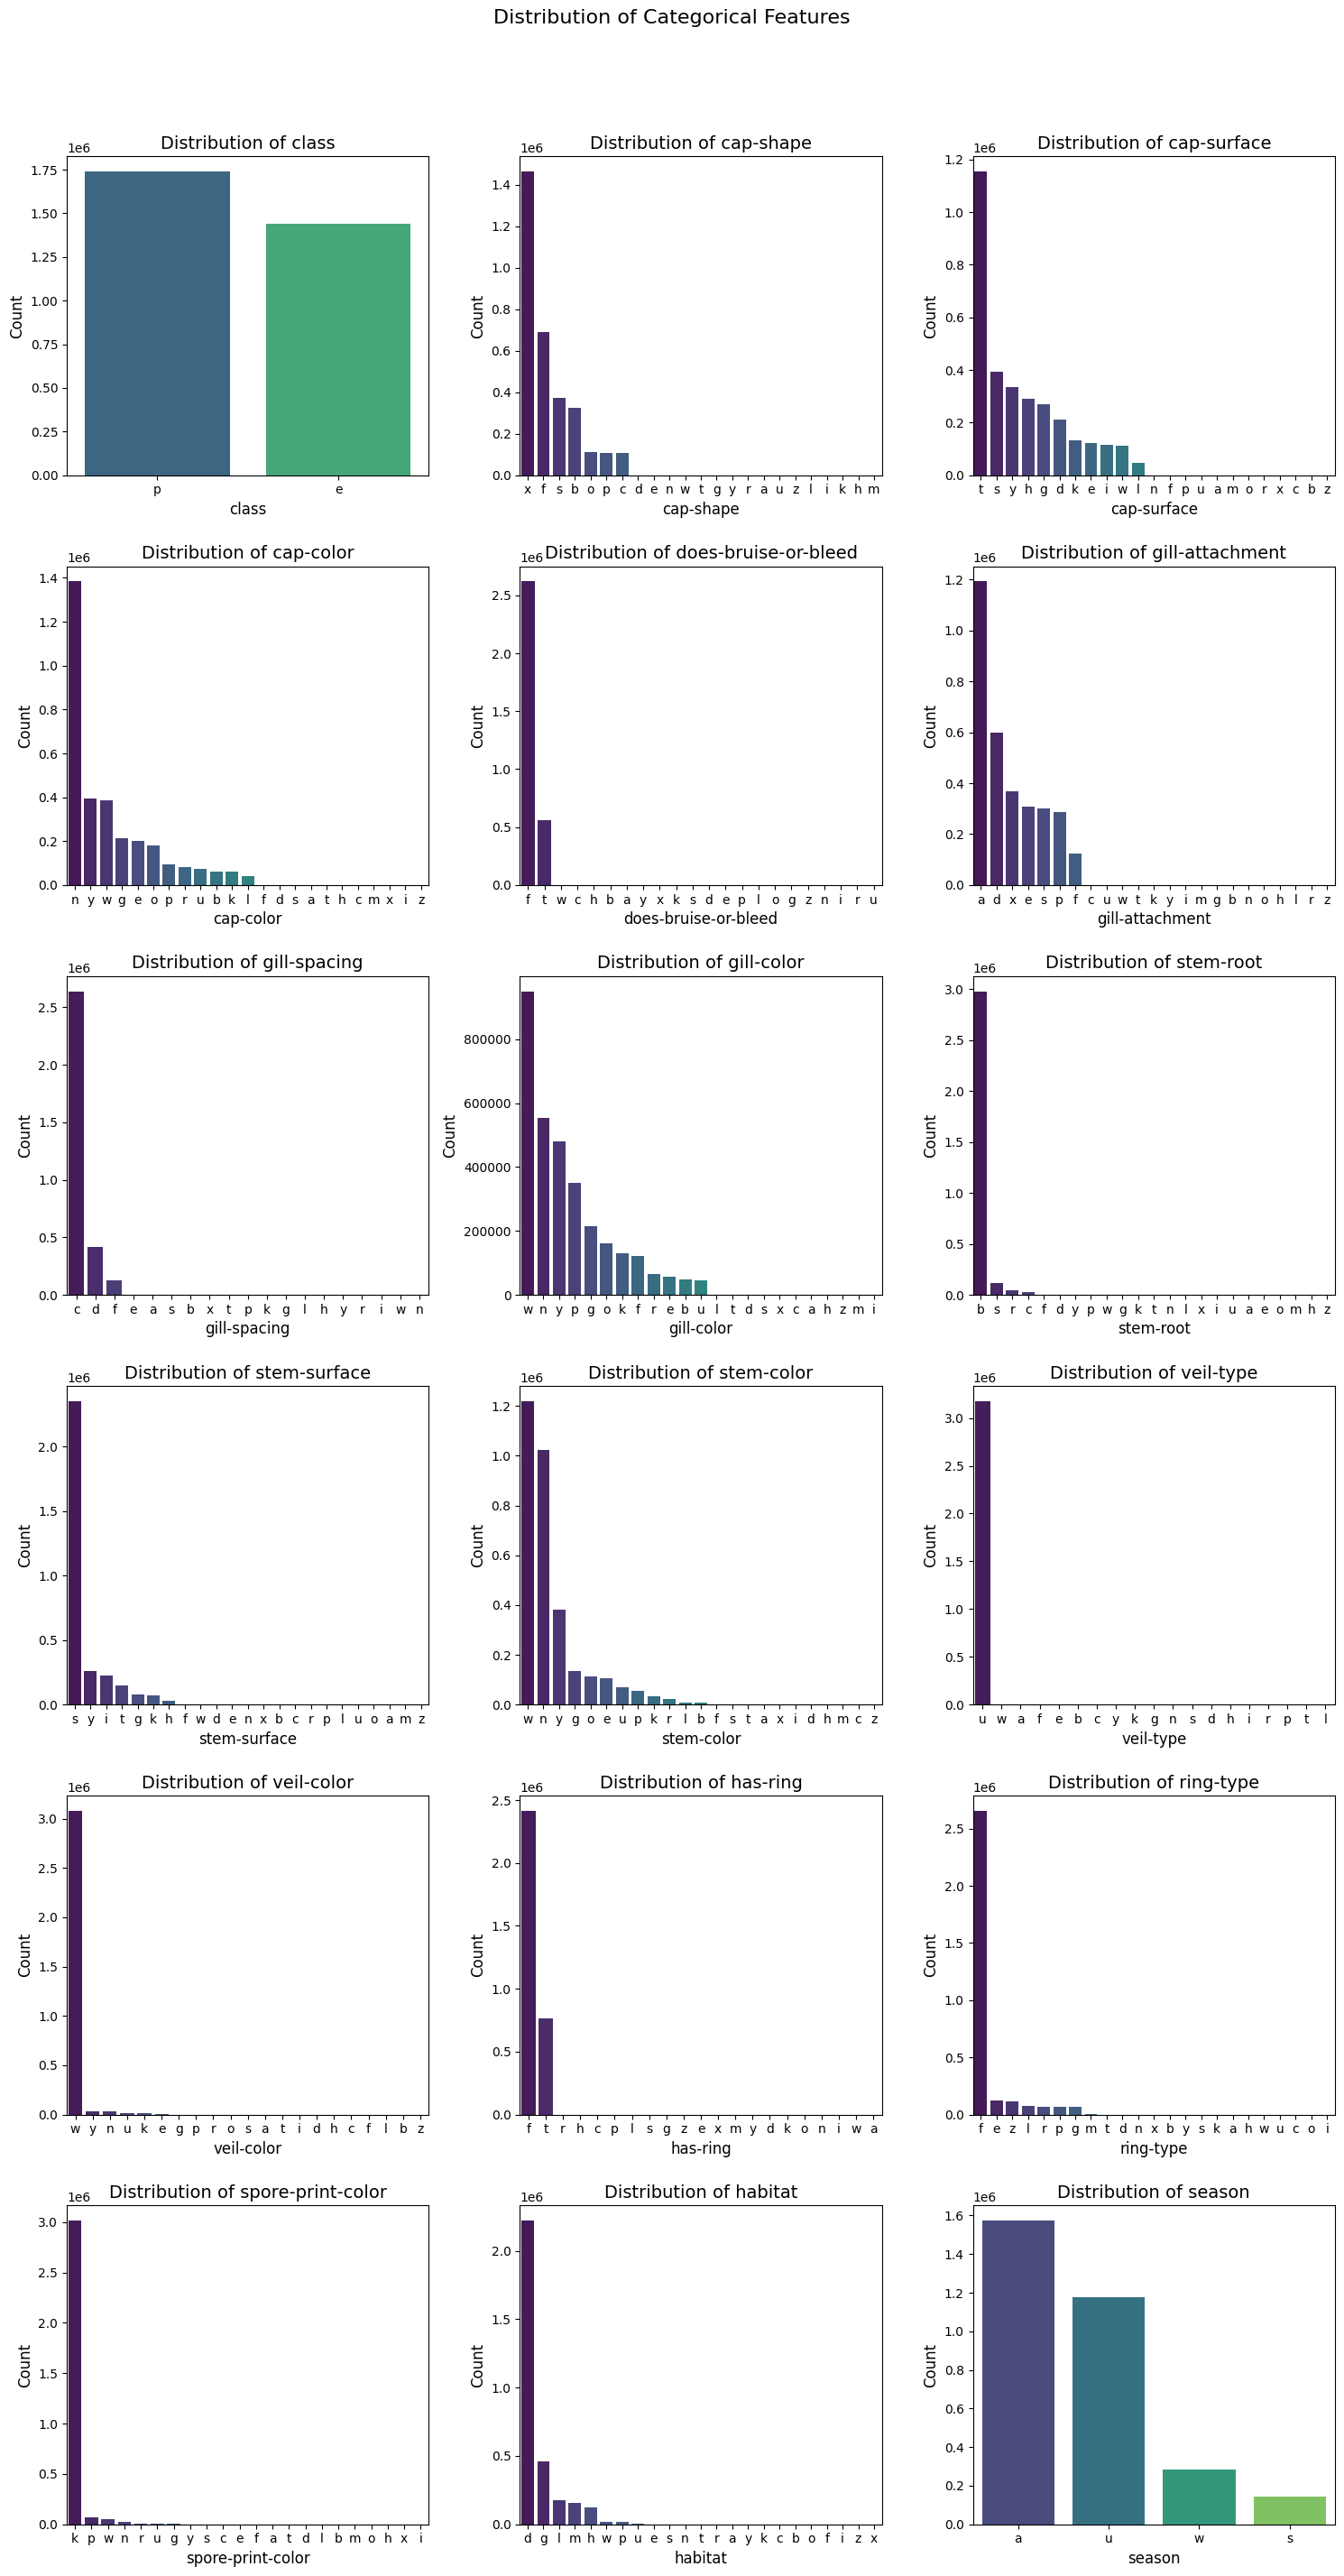

In [11]:
visualize_categorical_distributions(df)

### Handling Low-Frequency Categories
This function consolidates categories with frequencies below 100 into a single "Other" class across all categorical columns in both training and test datasets. By maintaining consistent mappings for low-frequency categories, we ensure model reliability and prevent data leakage between training and testing phases. This transformation simplifies our feature space and improves model stability.

In [3]:
def categorize_low_frequency_values(df_train, df_test, threshold=100):
    """
    Replaces categories with less than a given threshold in all categorical columns 
    with the category 'Unknown', applying the same transformation to both training and test datasets.
    
    Parameters:
    - df_train (pd.DataFrame): The training DataFrame.
    - df_test (pd.DataFrame): The test DataFrame.
    - threshold (int): Frequency threshold below which categories are replaced with 'Unknown'.

    Returns:
    - df_train (pd.DataFrame): Modified training DataFrame.
    - df_test (pd.DataFrame): Modified test DataFrame.
    - mapping_dict (dict): Dictionary containing the mappings of replaced values for each column.
    """
    mapping_dict = {}
    
    # Identify categorical columns
    categorical_columns = df_test.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        # Find values to replace
        value_counts = df_train[col].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index
        
        # Update mapping dictionary with replacement to 'Unknown'
        mapping_dict[col] = {value: 'Unknown' for value in values_to_replace}
        
        # Replace in training and test data
        df_train[col] = df_train[col].replace(values_to_replace, 'Unknown')
        df_test[col] = df_test[col].replace(values_to_replace, 'Unknown')

    return df_train, df_test, mapping_dict


In [4]:
df, test, mappings = categorize_low_frequency_values(df, test)

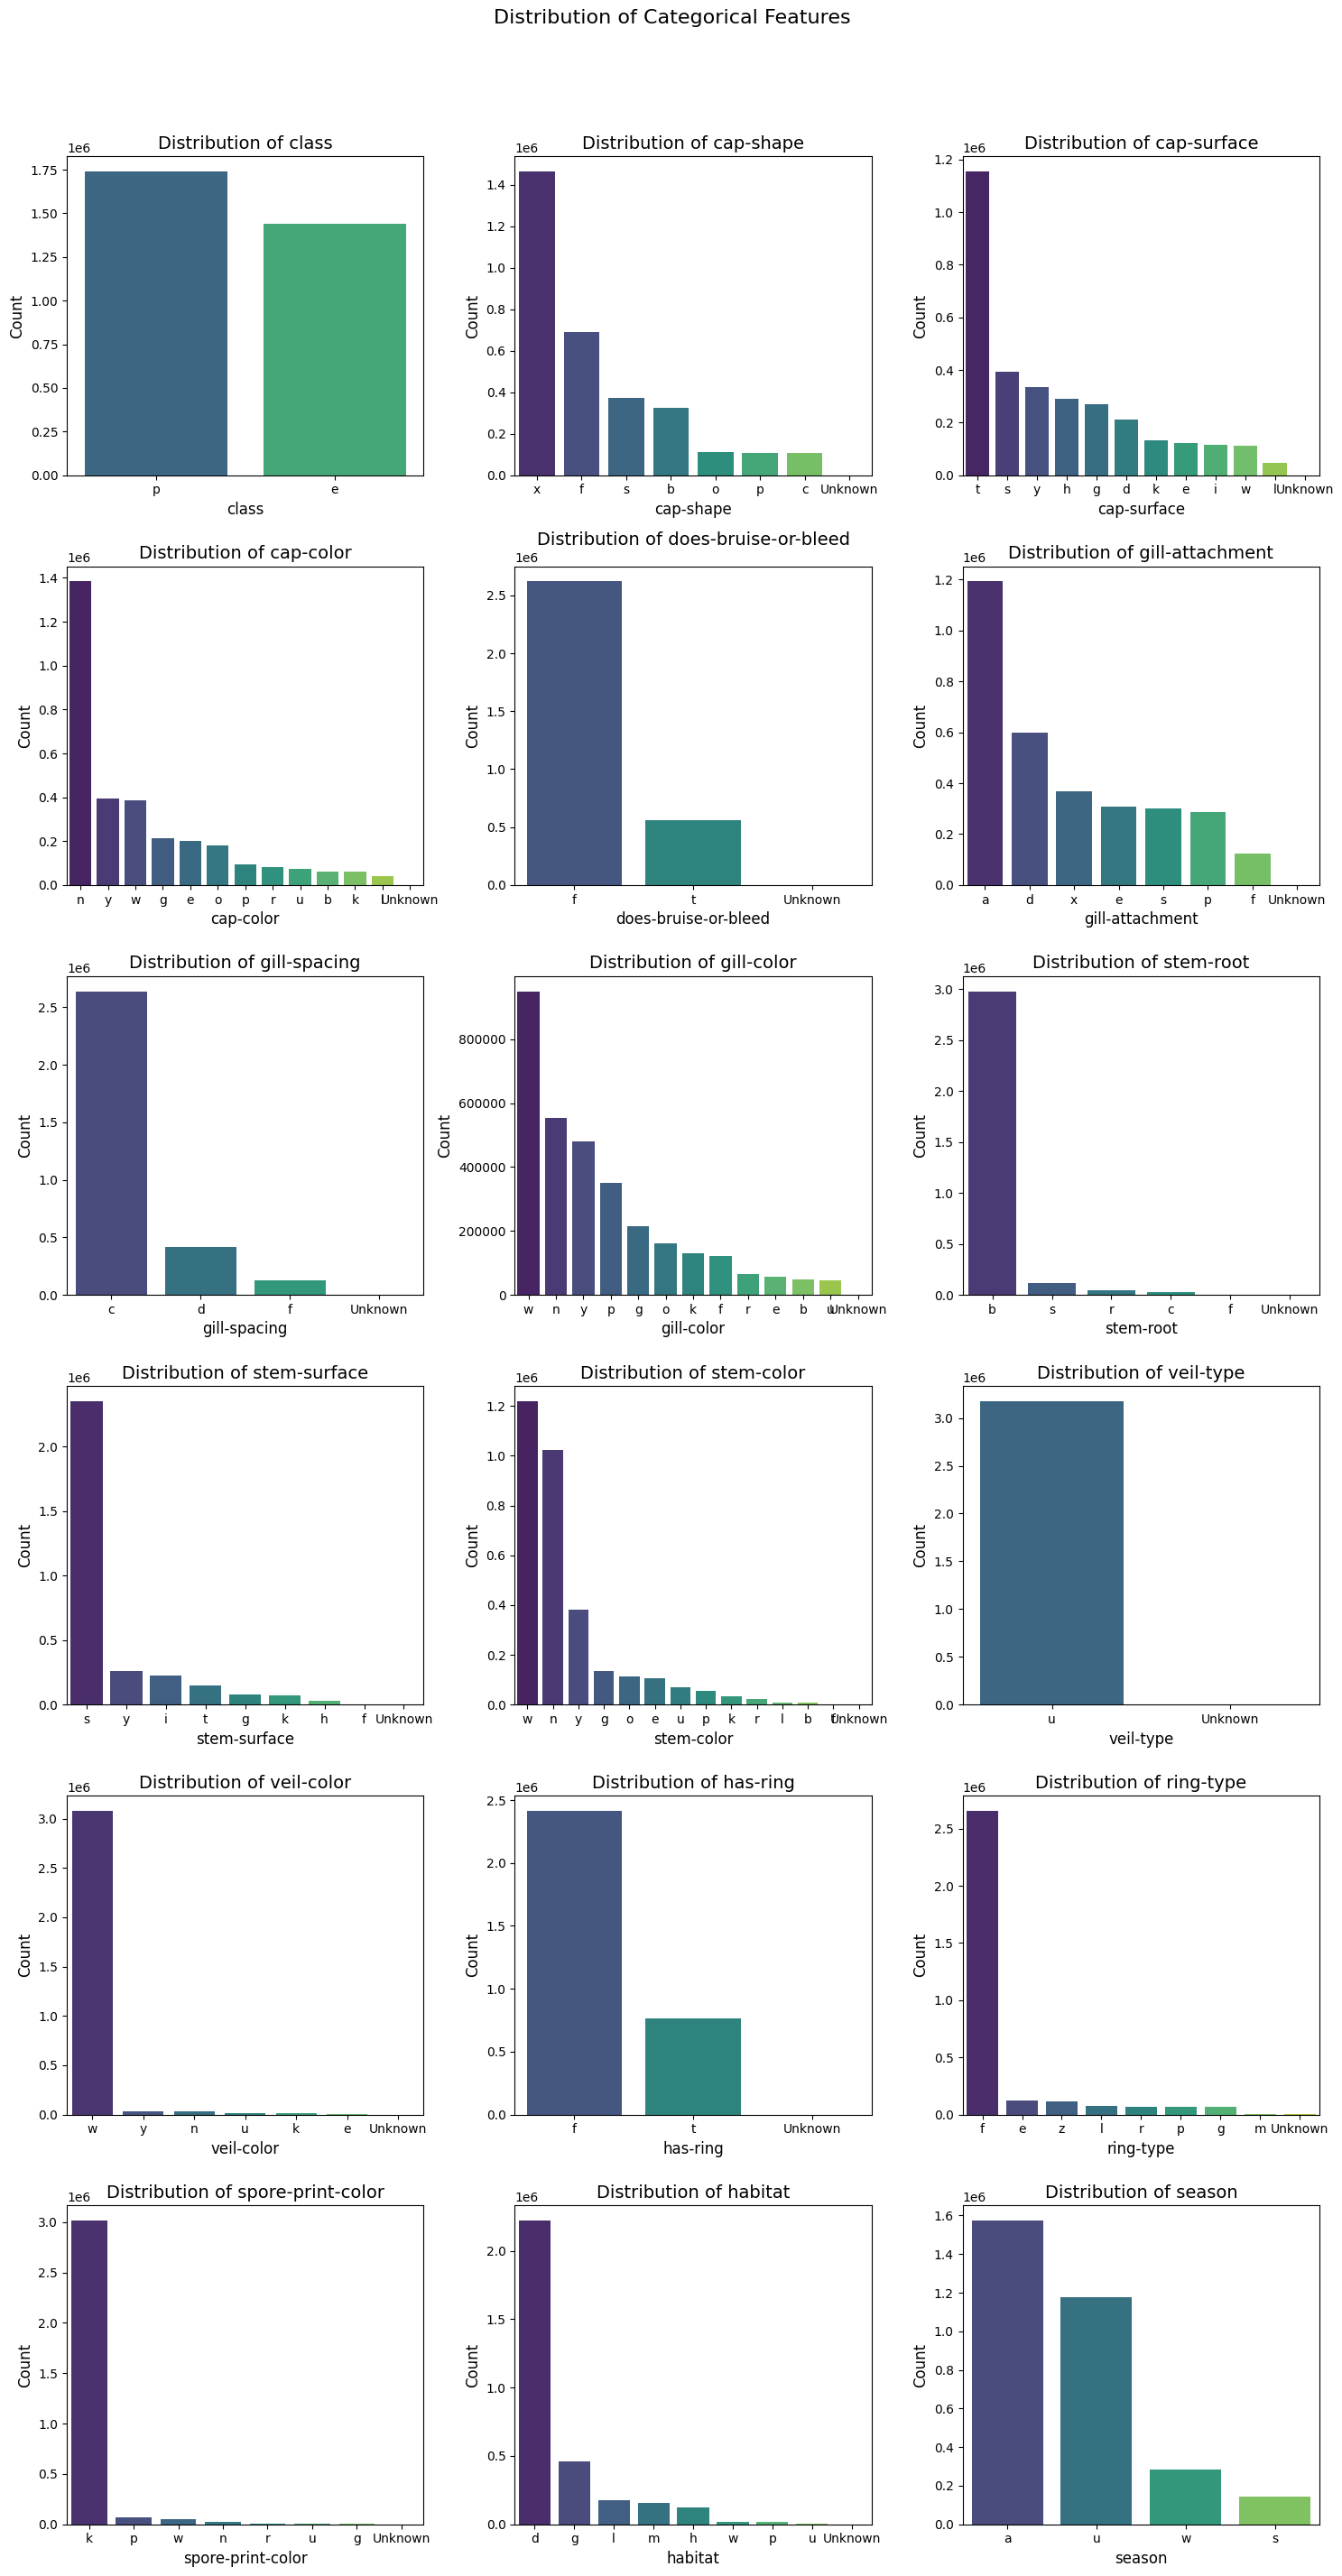

In [15]:
visualize_categorical_distributions(df)

### Visualizing Numerical Data Distributions
This function creates histograms and Kernel Density Estimate (KDE) plots for each numerical feature in a DataFrame. These visualizations help assess the distribution of numerical data, identifying skewness and the presence of outliers. By examining these plots, we can better understand the data's characteristics, which aids in making informed decisions on necessary data preprocessing steps such as normalization and outlier treatment. The visual output is especially useful for spotting distribution anomalies and verifying the effectiveness of any transformations applied to the data.

In [16]:
def visualize_numerical_distributions(df, exclude_columns='id'):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.
    
    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

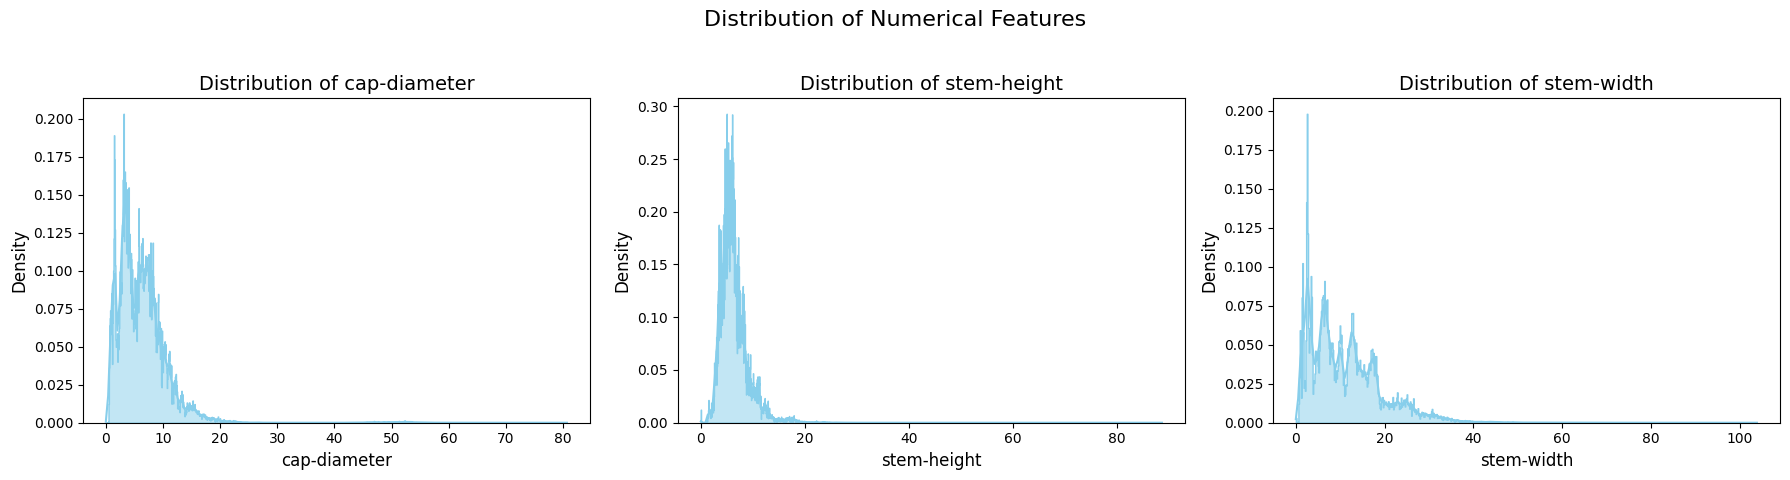

In [17]:
visualize_numerical_distributions(df)

### Adjusting Skewness in Numerical Features
Given the observed right skewness in features such as cap-diameter, stem-height, and stem-width, we've updated our skewness handling function to apply Box-Cox transformations selectively. This transformation will only be applied to features exhibiting a skewness greater than 1.0, targeting highly skewed distributions. This approach helps normalize these features, enhancing modeling efforts by stabilizing variance and making the data more conformant to the normal distribution assumptions required by many statistical modeling techniques. The transformation parameters (lambda values) are also retained for each feature, allowing for the precise reversal or consistent application to other data sets.

In [18]:
def handle_skewness(df, threshold=1.0):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame where skewness exceeds a threshold.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Skewness threshold to decide which columns to transform.
    
    Returns:
    - pd.DataFrame: DataFrame with transformed columns.
    - dict: Dictionary of lambda values used for Box-Cox transformation for each column.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    
    for col in numeric_cols:
        skewness = df[col].skew()
        # Check the skewness and ensure positive values for Box-Cox
        if skewness > threshold:
            # Adding 1 to shift all data to positive if there are zero or negative values
            df[col] = df[col] + 1
            df[col], fitted_lambda = boxcox(df[col])
            lambda_dict[col] = fitted_lambda
    
    return df, lambda_dict

# Example usage:
# df is your DataFrame containing the numerical data
df, lambda_values = handle_skewness(df)
test, lambda_test = handle_skewness(test)


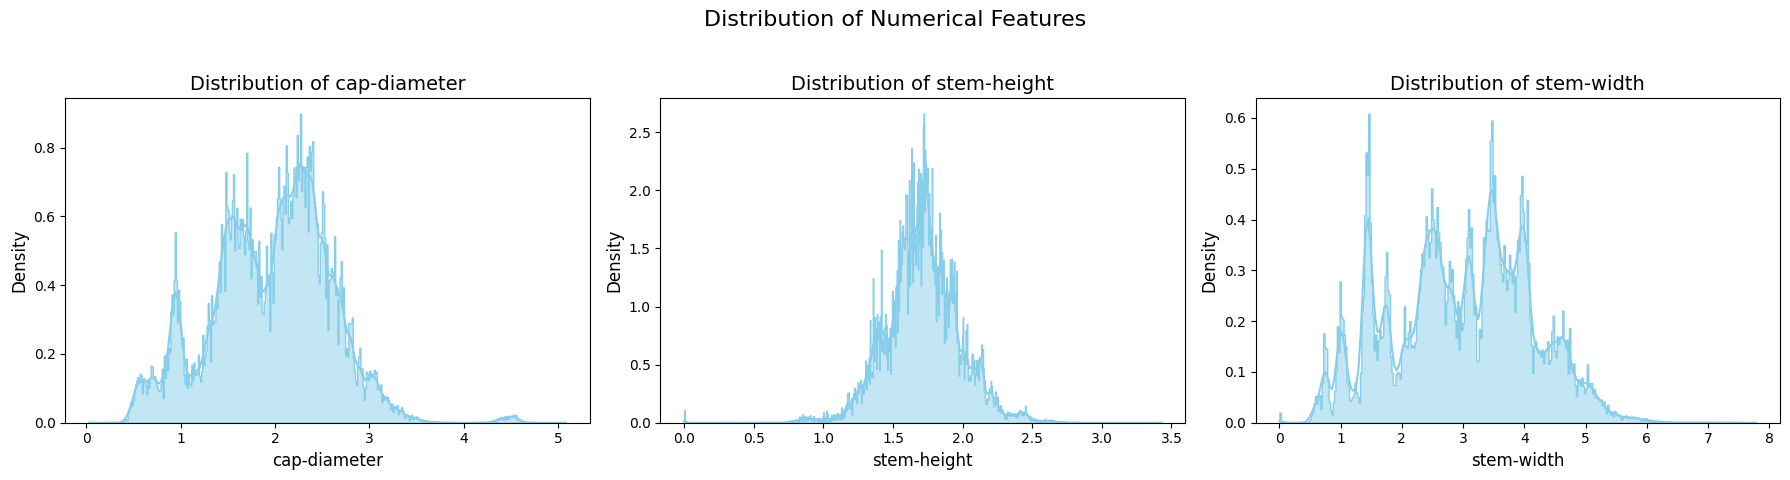

In [19]:
visualize_numerical_distributions(df, exclude_columns='id')

### Visualizing Outliers with Box Plots
The provided function visualize_box_plots is designed to plot the numerical data within a DataFrame using box plots. Each plot displays the minimum, first quartile, median, third quartile, and maximum, with outliers clearly marked beyond the whiskers. This visual aid is crucial for quick outlier detection and helps in decisions regarding data cleaning or outlier handling strategies. Box plots are particularly useful because they do not only identify outliers but also provide a concise summary of the data's distribution, including its central tendency and variability. By visualizing these plots, one can effectively assess the need for further data processing steps such as outlier removal or transformation.

In [20]:
def visualize_box_plots(df):
    """
    Visualizes the distribution of numerical features in the DataFrame using box plots to identify outliers.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    
    Returns:
    - None: Displays the box plots.
    """
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Box Plot of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a box plot
    for i, col in enumerate(numerical_columns):
        sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f'Box Plot of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

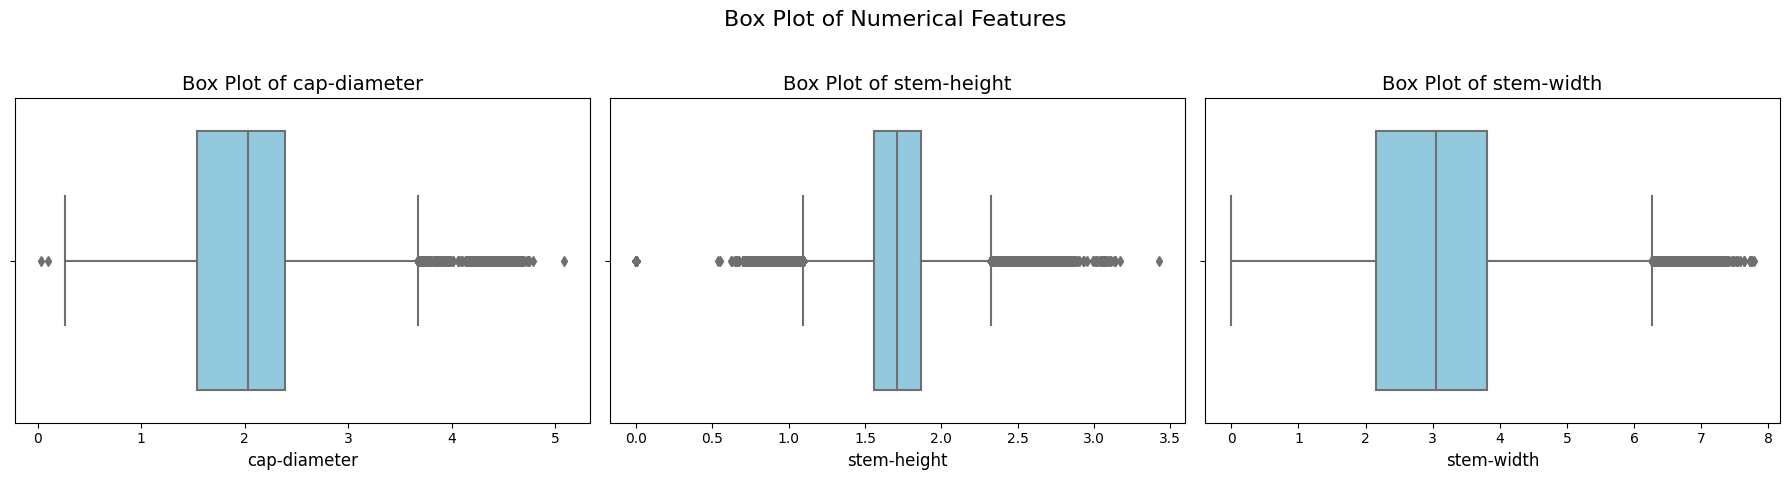

In [21]:
visualize_box_plots(df)

In [22]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

# Example usage:
calculate_outliers_percentage(df)


Percentage of outliers in cap-diameter: 0.44%
Percentage of outliers in stem-height: 2.64%
Percentage of outliers in stem-width: 0.06%


### Managing Outliers in Numerical Data
The function handle_outliers caps values beyond 1.5 times the interquartile range (IQR) from the first and third quartiles. This approach, known as the IQR method, is effective for reducing the impact of extreme outliers without losing valuable data. By capping rather than removing these points, we retain all records for analysis, ensuring robustness in our statistical tests and models. This method is applied to both the training and test datasets to maintain consistency in data processing, crucial for accurate model evaluation. The handling of outliers helps stabilize the datasets, making them more uniform and enhancing the predictive performance of subsequent modeling steps.

In [23]:
def handle_outliers(df):
    """
    Handles outliers in a DataFrame by capping based on the IQR method.

    Parameters:
    - df (pd.DataFrame): DataFrame to process.

    Returns:
    - pd.DataFrame: DataFrame with outliers handled.
    """
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Capping
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Apply to both training and test datasets
df = handle_outliers(df)
test = handle_outliers(test)

### Encoding Categorical Data for Modeling
The provided code snippet utilizes OrdinalEncoder to convert categorical columns in the training and test datasets into numeric formats. This approach is particularly useful when the categorical data has a natural order or ranking (though it can be applied more broadly). The encoder is first fitted to the training data, learning the unique categories and their order. It is then used to transform these categories into numeric codes in both the training and test datasets. This method ensures that the model treats the categories as ordered data and maintains consistency across different data sets, which is crucial for the performance and validity of machine learning models.

### Scaler Numerical Data

In [5]:
numeric_features = ['cap-diameter', 'stem-height', 'stem-width']

# Extract numeric features for training and test datasets
X_train_numeric = df[numeric_features]
X_test_numeric = test[numeric_features]

# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

df[numeric_features] = X_train_scaled
test[numeric_features] = X_test_scaled

In [6]:
# prepare target
y = df['class']  # Target

# Encoding the label
le = LabelEncoder()
df['class'] = y = le.fit_transform(df['class'])

In [7]:
# Encoding the features
cat_cols_train = df.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df[cat_cols_train] = ordinal_encoder.fit_transform(df[cat_cols_train].astype(str))
test[cat_cols_train] = ordinal_encoder.transform(test[cat_cols_train].astype(str))


In [8]:
# Prepare features
X = df.drop(['class'], axis=1)  # Features
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify=df['class'])


## Machine Learning

### Evaluation (Matthews Correlation Coefficient metric)
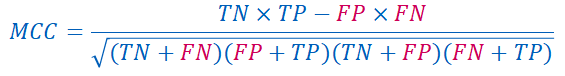

In [9]:
# mattews metrics for this competiton
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [10]:
# Define the parameters for the XGBoost classifier
xgb_optuna_params = {
    'n_estimators': 10000,
    'alpha': 0.0002,
    'subsample': 0.60,
    'colsample_bytree': 0.4,
    'max_depth': 13, 
    'min_child_weight': 10,
    'learning_rate': 0.002,
    'gamma': 5.6e-08,
    # 'tree_method': 'gpu_hist',
    # 'device': "cuda"
}

# Garbage collection to free up memory
gc.collect()

# Initialize the XGBClassifier with the specified parameters
xgbclf = XGBClassifier(**xgb_optuna_params, tree_method='gpu_hist')

# Fit the model on the training data and evaluate using the MCC metric
XGB = xgbclf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric=mcc_metric,
#     early_stopping_rounds=100,
    verbose=200,
)

y_pred = xgbclf.predict(X_test)
test_pred = xgbclf.predict(test.drop('id', axis=1))

[0]	validation_0-logloss:0.68738	validation_0-mcc:0.00000
[200]	validation_0-logloss:0.47087	validation_0-mcc:0.97989
[400]	validation_0-logloss:0.33868	validation_0-mcc:0.98314
[600]	validation_0-logloss:0.24998	validation_0-mcc:0.98348
[800]	validation_0-logloss:0.19048	validation_0-mcc:0.98357
[1000]	validation_0-logloss:0.14893	validation_0-mcc:0.98367
[1200]	validation_0-logloss:0.11940	validation_0-mcc:0.98380
[1400]	validation_0-logloss:0.09784	validation_0-mcc:0.98388
[1600]	validation_0-logloss:0.08235	validation_0-mcc:0.98390
[1800]	validation_0-logloss:0.07061	validation_0-mcc:0.98403
[2000]	validation_0-logloss:0.06193	validation_0-mcc:0.98411
[2200]	validation_0-logloss:0.05537	validation_0-mcc:0.98424
[2400]	validation_0-logloss:0.05054	validation_0-mcc:0.98431
[2600]	validation_0-logloss:0.04688	validation_0-mcc:0.98442
[2800]	validation_0-logloss:0.04414	validation_0-mcc:0.98448
[3000]	validation_0-logloss:0.04214	validation_0-mcc:0.98451
[3200]	validation_0-logloss:0.0

In [11]:
# Prepare submission
test_pred_labels = le.inverse_transform(test_pred)

sub['class'] = test_pred_labels
sub.to_csv('submission.csv', index=False)

In [15]:
# Print accuracy and classification report
def mcc_metric(y_pred, y_true):
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc


print(f"\nMathews Cor Coef: {mcc_metric(y_test, y_pred)}")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Mathews Cor Coef: ('mcc', 0.9853244842714886)

Accuracy: 0.9927246866611913

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    287746
           1       0.99      0.99      0.99    347828

    accuracy                           0.99    635574
   macro avg       0.99      0.99      0.99    635574
weighted avg       0.99      0.99      0.99    635574



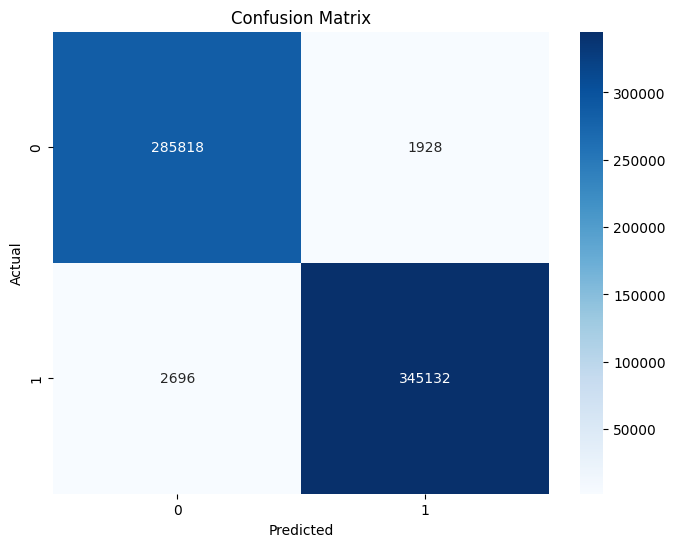

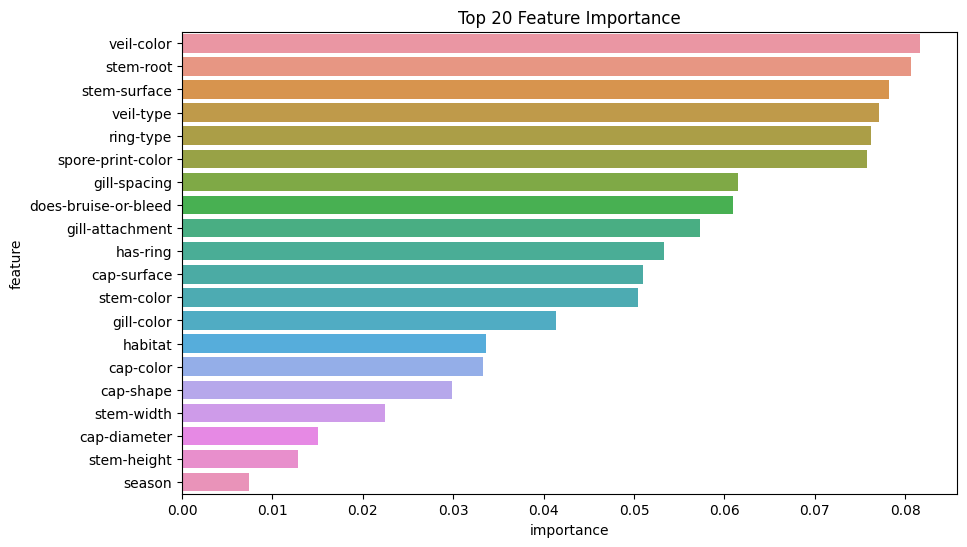

In [14]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot feature importance
feature_importance = xgbclf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()